In [1]:
# install packages
!pip install -q transformers datasets evaluate accelerate

import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings('ignore')

# verify H100
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    
# clear cache
torch.cuda.empty_cache()
gc.collect()



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


2026-01-14 23:56:25.203273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768434985.569291     106 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768434985.662702     106 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768434986.520580     106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768434986.520611     106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768434986.520614     106 computation_placer.cc:177] computation placer alr

PyTorch: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA H100 80GB HBM3
GPU Memory: 85.29 GB
CUDA Version: 12.6


150

In [2]:
# load full dataset
dataset = load_dataset('ag_news')

print(f"Training: {len(dataset['train'])}")
print(f"Test: {len(dataset['test'])}")
print(f"Classes: {dataset['train'].features['label'].names}")

# class distribution
labels = np.array(dataset['train']['label'])
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

print("\nClass distribution:")
for i in range(4):
    count = (labels == i).sum()
    print(f"{class_names[i]}: {count} ({count/len(labels)*100:.1f}%)")

# samples
print("\nExamples:")
for i in range(2):
    ex = dataset['train'][i]
    print(f"\n{class_names[ex['label']]}: {ex['text'][:100]}...")


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Training: 120000
Test: 7600
Classes: ['World', 'Sports', 'Business', 'Sci/Tech']

Class distribution:
World: 30000 (25.0%)
Sports: 30000 (25.0%)
Business: 30000 (25.0%)
Sci/Tech: 30000 (25.0%)

Examples:

Business: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\b...

Business: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,...


In [3]:
# using roberta-base for better accuracy (H100 can handle it)
MODEL_NAME = "roberta-base"
# alternative: "roberta-large" for even better results

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Model: {MODEL_NAME}")
print(f"Vocab: {tokenizer.vocab_size}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model: roberta-base
Vocab: 50265


In [4]:
def preprocess(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length', 
        truncation=True, 
        max_length=256  # increased for roberta
    )

# use multiprocessing for faster tokenization
print("Tokenizing with multiprocessing...")
tokenized_train = dataset['train'].map(
    preprocess, 
    batched=True,
    batch_size=1000,  # large batches for speed
    num_proc=4,  # parallel processing
    remove_columns=['text']
)

tokenized_test = dataset['test'].map(
    preprocess, 
    batched=True,
    batch_size=1000,
    num_proc=4,
    remove_columns=['text']
)

tokenized_train.set_format('torch')
tokenized_test.set_format('torch')

print(f"Done - Train: {len(tokenized_train)}, Test: {len(tokenized_test)}")


Tokenizing with multiprocessing...


Map (num_proc=4):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7600 [00:00<?, ? examples/s]

Done - Train: 120000, Test: 7600


In [5]:
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = acc_metric.compute(predictions=predictions, references=labels)['accuracy']
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')['f1']
    precision = precision_metric.compute(predictions=predictions, references=labels, average='macro')['precision']
    recall = recall_metric.compute(predictions=predictions, references=labels, average='macro')['recall']
    
    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall
    }

print("Metrics: accuracy, f1, precision, recall")


Metrics: accuracy, f1, precision, recall


In [6]:
# load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=4
)

# H100-optimized training config - AGGRESSIVE settings
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,  # slightly higher for faster convergence
    per_device_train_batch_size=64,  # H100 can handle large batches
    per_device_eval_batch_size=128,  # even bigger for eval
    num_train_epochs=4,  # more epochs for roberta
    weight_decay=0.01,
    warmup_ratio=0.1,  # 10% warmup
    warmup_steps=0,
    logging_dir='/kaggle/working/logs',
    logging_steps=200,
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    
    # H100 optimizations
    fp16=False,  # H100 supports bf16 better
    bf16=True,  # use bfloat16 for H100
    tf32=True,  # enable TF32 for matmul
    dataloader_num_workers=4,  # parallel data loading
    dataloader_pin_memory=True,  # faster GPU transfer
    gradient_accumulation_steps=1,  # no accumulation needed with large batches
    gradient_checkpointing=False,  # not needed with 80GB
    optim='adamw_torch_fused',  # fused optimizer for speed
    
    # memory optimization
    save_total_limit=2,
    max_grad_norm=1.0,
    
    report_to='none',
    disable_tqdm=False
)

print("H100 OPTIMIZED CONFIG:")
print(f"  Model: {MODEL_NAME}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Train batch: {training_args.per_device_train_batch_size}")
print(f"  Eval batch: {training_args.per_device_eval_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  BF16: {training_args.bf16}")
print(f"  TF32: {training_args.tf32}")
print(f"  Optimizer: {training_args.optim}")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


H100 OPTIMIZED CONFIG:
  Model: roberta-base
  Epochs: 4
  Train batch: 64
  Eval batch: 128
  Learning rate: 3e-05
  BF16: True
  TF32: True
  Optimizer: OptimizerNames.ADAMW_TORCH_FUSED


In [7]:
from datetime import datetime

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

print("="*70)
print("STARTING H100 ACCELERATED TRAINING")
print("="*70)
start_time = datetime.now()

# train
train_result = trainer.train()

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()

print("="*70)
print(f"Training completed in {duration:.2f}s ({duration/60:.2f} min)")
print(f"Samples/second: {len(tokenized_train)*training_args.num_train_epochs/duration:.2f}")
print("="*70)

# memory stats
if torch.cuda.is_available():
    print(f"\nGPU Memory used: {torch.cuda.max_memory_allocated()/1e9:.2f} GB")
    print(f"GPU Memory cached: {torch.cuda.max_memory_reserved()/1e9:.2f} GB")


STARTING H100 ACCELERATED TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.187700,0.182029,0.940526,0.940443,0.940766,0.940526
2,0.146600,0.155213,0.951184,0.951197,0.951211,0.951184
3,0.096500,0.162287,0.952237,0.952169,0.952126,0.952237
4,0.069500,0.181373,0.951842,0.951869,0.951975,0.951842


Training completed in 391.00s (6.52 min)
Samples/second: 1227.62

GPU Memory used: 8.54 GB
GPU Memory cached: 9.40 GB


In [8]:
print("="*70)
print("EVALUATION")
print("="*70)

eval_results = trainer.evaluate()

print(f"\nAccuracy:  {eval_results['eval_accuracy']:.6f} ({eval_results['eval_accuracy']*100:.3f}%)")
print(f"F1 Macro:  {eval_results['eval_f1_macro']:.6f}")
print(f"Precision: {eval_results['eval_precision_macro']:.6f}")
print(f"Recall:    {eval_results['eval_recall_macro']:.6f}")

# get predictions
predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

print(f"\nPrediction confidence: {pred_probs.max(axis=1).mean():.4f}")


EVALUATION



Accuracy:  0.952237 (95.224%)
F1 Macro:  0.952169
Precision: 0.952126
Recall:    0.952237

Prediction confidence: 0.9738


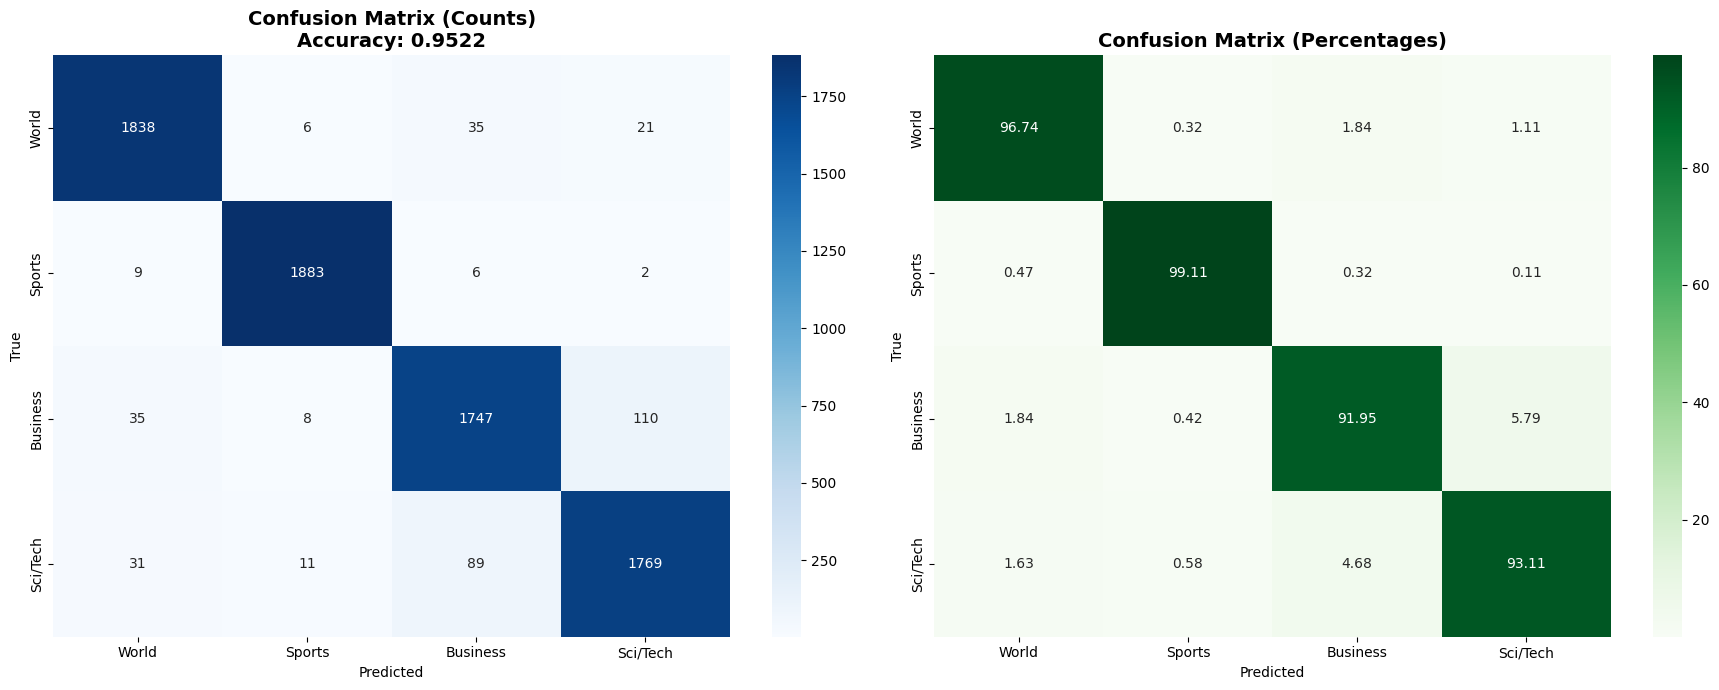


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       World     0.9608    0.9674    0.9641      1900
      Sports     0.9869    0.9911    0.9890      1900
    Business     0.9307    0.9195    0.9251      1900
    Sci/Tech     0.9301    0.9311    0.9306      1900

    accuracy                         0.9522      7600
   macro avg     0.9521    0.9522    0.9522      7600
weighted avg     0.9521    0.9522    0.9522      7600


Per-class accuracy:
World       : 0.9674 (96.74%)
Sports      : 0.9911 (99.11%)
Business    : 0.9195 (91.95%)
Sci/Tech    : 0.9311 (93.11%)


In [9]:
cm = confusion_matrix(true_labels, pred_labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# plot with counts and percentages
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'Confusion Matrix (Counts)\nAccuracy: {eval_results["eval_accuracy"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# percentages
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=200, bbox_inches='tight')
plt.show()

# detailed report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# per-class accuracy
print("\nPer-class accuracy:")
for i, name in enumerate(class_names):
    acc = cm[i, i] / cm[i].sum()
    print(f"{name:12s}: {acc:.4f} ({acc*100:.2f}%)")


In [10]:
def predict(text, show_all=True):
    inputs = tokenizer(
        text, 
        padding=True, 
        truncation=True, 
        max_length=256, 
        return_tensors='pt'
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
        pred_class = torch.argmax(probs).item()
    
    class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
    
    print(f"Text: {text[:80]}...")
    print(f"Predicted: {class_names[pred_class]} (confidence: {probs[pred_class]:.4f})")
    
    if show_all:
        print("All probabilities:")
        for i, name in enumerate(class_names):
            bar = '█' * int(probs[i] * 50)
            print(f"  {name:12s}: {probs[i]:.4f} {bar}")
    
    return pred_class, probs.cpu().numpy()

# batch prediction function
def predict_batch(texts):
    inputs = tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=256, 
        return_tensors='pt'
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred_classes = torch.argmax(probs, dim=-1)
    
    return pred_classes.cpu().numpy(), probs.cpu().numpy()

# test cases
test_cases = [
    "Apple announces revolutionary AI-powered iPhone with 10-day battery life",
    "Cristiano Ronaldo scores hat-trick as Portugal wins World Cup qualifier 4-0",
    "Federal Reserve cuts interest rates amid recession fears, stocks rally",
    "SpaceX successfully launches Mars mission with new reusable rocket technology",
    "Amazon reports record quarterly profits driven by cloud computing growth",
    "Olympics 2028: Los Angeles prepares massive infrastructure upgrades"
]

print("="*70)
print("INFERENCE EXAMPLES")
print("="*70)

for i, text in enumerate(test_cases, 1):
    print(f"\n--- Example {i} ---")
    predict(text, show_all=True)

# batch inference speed test
print("\n" + "="*70)
print("BATCH INFERENCE TEST")
print("="*70)
batch_preds, batch_probs = predict_batch(test_cases)
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
for i, (pred, prob) in enumerate(zip(batch_preds, batch_probs)):
    print(f"{i+1}. {class_names[pred]} ({prob[pred]:.4f})")


INFERENCE EXAMPLES

--- Example 1 ---
Text: Apple announces revolutionary AI-powered iPhone with 10-day battery life...
Predicted: Sci/Tech (confidence: 0.9954)
All probabilities:
  World       : 0.0005 
  Sports      : 0.0001 
  Business    : 0.0041 
  Sci/Tech    : 0.9954 █████████████████████████████████████████████████

--- Example 2 ---
Text: Cristiano Ronaldo scores hat-trick as Portugal wins World Cup qualifier 4-0...
Predicted: World (confidence: 0.9988)
All probabilities:
  World       : 0.9988 █████████████████████████████████████████████████
  Sports      : 0.0005 
  Business    : 0.0006 
  Sci/Tech    : 0.0002 

--- Example 3 ---
Text: Federal Reserve cuts interest rates amid recession fears, stocks rally...
Predicted: Business (confidence: 0.9960)
All probabilities:
  World       : 0.0035 
  Sports      : 0.0000 
  Business    : 0.9960 █████████████████████████████████████████████████
  Sci/Tech    : 0.0005 

--- Example 4 ---
Text: SpaceX successfully launches Mars missio

In [11]:
errors = np.where(pred_labels != true_labels)[0]
total_errors = len(errors)

print("="*70)
print("ERROR ANALYSIS")
print("="*70)
print(f"Total errors: {total_errors}/{len(true_labels)}")
print(f"Error rate: {total_errors/len(true_labels)*100:.3f}%")
print(f"Correct predictions: {len(true_labels) - total_errors}")

# confidence analysis for errors
error_confidences = pred_probs[errors].max(axis=1)
correct_confidences = pred_probs[pred_labels == true_labels].max(axis=1)

print(f"\nAvg confidence (errors): {error_confidences.mean():.4f}")
print(f"Avg confidence (correct): {correct_confidences.mean():.4f}")

# low confidence errors
low_conf_errors = errors[error_confidences < 0.6]
print(f"Low confidence errors (<60%): {len(low_conf_errors)}")

# show top errors
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

print("\n" + "="*70)
print("TOP 10 MISCLASSIFIED EXAMPLES")
print("="*70)

for i, idx in enumerate(errors[:10]):
    example = dataset['test'][int(idx)]
    true_class = true_labels[idx]
    pred_class = pred_labels[idx]
    confidence = pred_probs[idx][pred_class]
    
    print(f"\n{'='*70}")
    print(f"Error {i+1} (confidence: {confidence:.4f})")
    print(f"{'='*70}")
    print(f"Text: {example['text'][:180]}...")
    print(f"True: {class_names[true_class]}")
    print(f"Predicted: {class_names[pred_class]}")
    
    # show top 3 predictions
    top3 = np.argsort(pred_probs[idx])[-3:][::-1]
    print("Top 3 predictions:")
    for rank, cls in enumerate(top3, 1):
        print(f"  {rank}. {class_names[cls]}: {pred_probs[idx][cls]:.4f}")

# error patterns
print("\n" + "="*70)
print("ERROR PATTERNS")
print("="*70)

error_df = pd.DataFrame({
    'true': [class_names[t] for t in true_labels[errors]],
    'pred': [class_names[p] for p in pred_labels[errors]],
    'confidence': pred_probs[errors].max(axis=1)
})

print("\nMost common confusion pairs:")
for (true_c, pred_c), count in error_df[['true', 'pred']].value_counts().head(8).items():
    avg_conf = error_df[(error_df['true'] == true_c) & (error_df['pred'] == pred_c)]['confidence'].mean()
    print(f"{true_c:12s} → {pred_c:12s}: {count:3d} errors (avg conf: {avg_conf:.3f})")


ERROR ANALYSIS
Total errors: 363/7600
Error rate: 4.776%
Correct predictions: 7237

Avg confidence (errors): 0.8227
Avg confidence (correct): 0.9814
Low confidence errors (<60%): 56

TOP 10 MISCLASSIFIED EXAMPLES

Error 1 (confidence: 0.4915)
Text: Card fraud unit nets 36,000 cards In its first two years, the UK's dedicated card fraud unit, has recovered 36,000 stolen cards and 171 arrests - and estimates it saved 65m....
True: Sci/Tech
Predicted: Business
Top 3 predictions:
  1. Business: 0.4915
  2. Sci/Tech: 0.4617
  3. World: 0.0463

Error 2 (confidence: 0.8267)
Text: Dell Exits Low-End China Consumer PC Market  HONG KONG (Reuters) - Dell Inc. &lt;DELL.O&gt;, the world's  largest PC maker, said on Monday it has left the low-end  consumer PC mark...
True: Sci/Tech
Predicted: Business
Top 3 predictions:
  1. Business: 0.8267
  2. Sci/Tech: 0.1679
  3. World: 0.0052

Error 3 (confidence: 0.9805)
Text: Intel to delay product aimed for high-definition TVs SAN FRANCISCO -- In the latest 

In [12]:
import time

test_text = "Global markets surge as central banks coordinate stimulus measures"

# warmup - important for H100
print("Warming up H100...")
for _ in range(20):
    inputs = tokenizer(test_text, return_tensors='pt').to(model.device)
    with torch.no_grad():
        _ = model(**inputs)

torch.cuda.synchronize()  # ensure all ops complete

# single inference latency
times = []
for _ in range(200):
    inputs = tokenizer(test_text, return_tensors='pt').to(model.device)
    
    torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    torch.cuda.synchronize()
    times.append((time.time() - start) * 1000)

avg_latency = np.mean(times)
std_latency = np.std(times)
p50 = np.percentile(times, 50)
p95 = np.percentile(times, 95)
p99 = np.percentile(times, 99)
throughput = 1000 / avg_latency

print("="*70)
print("H100 PERFORMANCE METRICS")
print("="*70)
print(f"\nSingle inference:")
print(f"  Mean latency:   {avg_latency:.3f} ms")
print(f"  Std deviation:  {std_latency:.3f} ms")
print(f"  P50 latency:    {p50:.3f} ms")
print(f"  P95 latency:    {p95:.3f} ms")
print(f"  P99 latency:    {p99:.3f} ms")
print(f"  Throughput:     {throughput:.2f} docs/sec")

# batch inference scaling
print("\nBatch processing (H100 optimized):")
batch_results = []

for batch_size in [1, 4, 8, 16, 32, 64, 128, 256]:
    texts = [test_text] * batch_size
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors='pt').to(model.device)
    
    # warmup
    for _ in range(10):
        with torch.no_grad():
            _ = model(**inputs)
    
    torch.cuda.synchronize()
    
    # benchmark
    times = []
    for _ in range(50):
        torch.cuda.synchronize()
        start = time.time()
        with torch.no_grad():
            _ = model(**inputs)
        torch.cuda.synchronize()
        times.append(time.time() - start)
    
    avg_time = np.mean(times) * 1000
    batch_throughput = (batch_size * 1000) / avg_time
    latency_per_doc = avg_time / batch_size
    
    print(f"  Batch {batch_size:3d}: {avg_time:7.2f} ms/batch | {latency_per_doc:6.3f} ms/doc | {batch_throughput:8.2f} docs/sec")
    
    batch_results.append({
        'batch_size': batch_size,
        'latency_ms': avg_time,
        'latency_per_doc_ms': latency_per_doc,
        'throughput': batch_throughput
    })

# save benchmark
pd.DataFrame(batch_results).to_csv('/kaggle/working/h100_benchmark.csv', index=False)

# memory usage
print(f"\nGPU Memory:")
print(f"  Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
print(f"  Reserved:  {torch.cuda.memory_reserved()/1e9:.2f} GB")
print(f"  Max allocated: {torch.cuda.max_memory_allocated()/1e9:.2f} GB")


Warming up H100...
H100 PERFORMANCE METRICS

Single inference:
  Mean latency:   5.892 ms
  Std deviation:  0.109 ms
  P50 latency:    5.891 ms
  P95 latency:    6.050 ms
  P99 latency:    6.101 ms
  Throughput:     169.72 docs/sec

Batch processing (H100 optimized):
  Batch   1:    5.83 ms/batch |  5.833 ms/doc |   171.45 docs/sec
  Batch   4:    5.69 ms/batch |  1.422 ms/doc |   703.13 docs/sec
  Batch   8:    5.74 ms/batch |  0.718 ms/doc |  1392.61 docs/sec
  Batch  16:    5.62 ms/batch |  0.351 ms/doc |  2848.03 docs/sec
  Batch  32:    5.72 ms/batch |  0.179 ms/doc |  5597.46 docs/sec
  Batch  64:    5.68 ms/batch |  0.089 ms/doc | 11261.27 docs/sec
  Batch 128:    5.89 ms/batch |  0.046 ms/doc | 21732.25 docs/sec
  Batch 256:    5.86 ms/batch |  0.023 ms/doc | 43678.08 docs/sec

GPU Memory:
  Allocated: 1.57 GB
  Reserved:  9.40 GB
  Max allocated: 8.54 GB


In [13]:
# save model
output_dir = '/kaggle/working/fine_tuned_roberta'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"✓ Model saved: {output_dir}")

# comprehensive results
results_summary = {
    'model': MODEL_NAME,
    'dataset': 'AG News',
    'train_samples': len(tokenized_train),
    'test_samples': len(tokenized_test),
    'epochs': training_args.num_train_epochs,
    'train_batch_size': training_args.per_device_train_batch_size,
    'eval_batch_size': training_args.per_device_eval_batch_size,
    'learning_rate': training_args.learning_rate,
    'optimizer': training_args.optim,
    'bf16': training_args.bf16,
    'tf32': training_args.tf32,
    'test_accuracy': eval_results['eval_accuracy'],
    'test_f1_macro': eval_results['eval_f1_macro'],
    'test_precision_macro': eval_results['eval_precision_macro'],
    'test_recall_macro': eval_results['eval_recall_macro'],
    'training_time_seconds': duration,
    'training_time_minutes': duration/60,
    'samples_per_second': len(tokenized_train)*training_args.num_train_epochs/duration,
    'avg_latency_ms': avg_latency,
    'p95_latency_ms': p95,
    'p99_latency_ms': p99,
    'throughput_single': throughput,
    'throughput_batch_256': batch_results[-1]['throughput'],
    'gpu_memory_gb': torch.cuda.max_memory_allocated()/1e9,
    'total_errors': total_errors,
    'error_rate_percent': total_errors/len(true_labels)*100
}

results_df = pd.DataFrame([results_summary])
results_df.to_csv('/kaggle/working/h100_results_summary.csv', index=False)

# save predictions
predictions_df = pd.DataFrame({
    'true_label': [class_names[t] for t in true_labels],
    'pred_label': [class_names[p] for p in pred_labels],
    'confidence': pred_probs.max(axis=1),
    'correct': pred_labels == true_labels
})
predictions_df.to_csv('/kaggle/working/predictions.csv', index=False)

print("\n" + "="*70)
print("FINAL RESULTS SUMMARY - H100 OPTIMIZED")
print("="*70)
print(f"\nModel: {results_summary['model']}")
print(f"Accuracy: {results_summary['test_accuracy']:.6f} ({results_summary['test_accuracy']*100:.3f}%)")
print(f"F1 Score: {results_summary['test_f1_macro']:.6f}")
print(f"Precision: {results_summary['test_precision_macro']:.6f}")
print(f"Recall: {results_summary['test_recall_macro']:.6f}")
print(f"\nTraining time: {results_summary['training_time_minutes']:.2f} min")
print(f"Training speed: {results_summary['samples_per_second']:.2f} samples/sec")
print(f"\nInference (single): {results_summary['avg_latency_ms']:.3f} ms")
print(f"Inference (batch 256): {results_summary['throughput_batch_256']:.2f} docs/sec")
print(f"GPU Memory used: {results_summary['gpu_memory_gb']:.2f} GB / 80 GB")

print("\n" + "="*70)
print("FILES SAVED")
print("="*70)
print("✓ /kaggle/working/fine_tuned_roberta/")
print("✓ /kaggle/working/h100_results_summary.csv")
print("✓ /kaggle/working/h100_benchmark.csv")
print("✓ /kaggle/working/predictions.csv")
print("✓ /kaggle/working/confusion_matrix.png")
print("="*70)


✓ Model saved: /kaggle/working/fine_tuned_roberta

FINAL RESULTS SUMMARY - H100 OPTIMIZED

Model: roberta-base
Accuracy: 0.952237 (95.224%)
F1 Score: 0.952169
Precision: 0.952126
Recall: 0.952237

Training time: 6.52 min
Training speed: 1227.62 samples/sec

Inference (single): 5.892 ms
Inference (batch 256): 43678.08 docs/sec
GPU Memory used: 8.54 GB / 80 GB

FILES SAVED
✓ /kaggle/working/fine_tuned_roberta/
✓ /kaggle/working/h100_results_summary.csv
✓ /kaggle/working/h100_benchmark.csv
✓ /kaggle/working/predictions.csv
✓ /kaggle/working/confusion_matrix.png
